# Predictive Modeling

By: Rodrigo Hernández Mota

## Libraries

In [13]:
%matplotlib inline

import os
import setup
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [32]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR

from utils.performance_functions import rmsle
from utils.data_handler import CompetitionData, desnormalize, invLogTransf

## Download data

In [27]:
def create_dirs():
    setup.create_dir_if_exists('data')
    setup.create_dir_if_exists('output')
    
def download_data():
    filenames = ["train.csv", "test.csv", "enhanced_train.csv"]
    download_url = "https://rhdzmota-cloud-storage.herokuapp.com/temporal-link/dropbox-files?file_name={}&file_path={}"
    for file in filenames:
        if os.path.isfile("data/" + file):
            continue
        r = requests.get(download_url.format(file, "/kaggle/nyc-taxi"))
        f = requests.get(r.json().get("url"))
        with open("data/"+file, "wb") as code:
            code.write(f.content)
        
create_dirs()
download_data() 

## Auxiliar Functions

In [28]:
def desnorm_y(comp_data, y_norm):
    return np.array([desnormalize(np.asscalar(i),
                                             comp_data.train_dataset,
                                             comp_data.normalize_method) for i in y_norm])


def drop_one_dim(y):
    first, second = y.shape
    return y.reshape((first, ))


def print_vals(model, train_rmsle, test_rmsle):
    string = 'Model: {}\nTrain: {}\nTest: {}'.format(
        model, train_rmsle, test_rmsle)
    print(string)


def plot_estimations(real_y, estimate_y, title):
    percentile_90 = np.percentile(real_y, 95)
    real_list, estimate_list = [], []
    for real, estimate in zip(real_y, estimate_y):
        if real > 90:
            continue
        real_list.append(real)
        estimate_list.append(estimate)
    plt.plot(real_list, real_list, ".b", label="real-values")
    plt.plot(real_list, estimate_list, ".g", alpha=0.7, label="estimations")
    plt.title(title)
    plt.legend()
    plt.xlabel("s")
    plt.ylabel("s")
    plt.show()
    

def plot_errors(real_y, estimate_y, title):
    percentile_90 = np.percentile(real_y, 95)
    real_list, estimate_list = [], []
    for real, estimate in zip(real_y, estimate_y):
        if real > 90:
            continue
        real_list.append(real)
        estimate_list.append(estimate)
    df = pd.DataFrame(np.array(real_list) - np.array(estimate_list))
    df.plot(kind="kde")
    plt.title(title)
    plt.show()
    
def submit_function(ml_model, comp_data, params, filename):
    if params.submit:
        subm_data = comp_data.submit_dataset() if comp_data.submit_data is None else comp_data.submit_data
        sumbit_log_estimates = ml_model.predict(subm_data)
        sumbit_estimates = invLogTransf(desnorm_y(comp_data, sumbit_log_estimates))
        sumbit = pd.DataFrame({"id": comp_data.raw_submit['id'].values,
                               "trip_duration": sumbit_estimates})
        sumbit.to_csv("output/{}".format(filename), index=False)


## Models functions

In [29]:
def regressor_procedure(ml_model, comp_data, model_desc):
    # Datasets
    x_train, y_train = comp_data.train_dataset.train
    x_test, y_test = comp_data.train_dataset.test
    x_validate, y_validate = comp_data.train_dataset.validate
    # Fit
    ml_model.fit(x_train, drop_one_dim(y_train))
    # Estimates
    train_estimates = ml_model.predict(x_train)
    test_estimates = ml_model.predict(x_test)
    validate_estimates = ml_model.predict(x_validate)
    # Desnorm
    desnorm_train_y = desnorm_y(comp_data, y_train)
    desnorm_train_yest = desnorm_y(comp_data, train_estimates)
    desnorm_test_y = desnorm_y(comp_data, y_test)
    desnorm_test_yest = desnorm_y(comp_data, test_estimates)
    desnorm_validate_y = desnorm_y(comp_data, y_validate)
    desnorm_validate_yest = desnorm_y(comp_data, validate_estimates)
    # RMSLE
    train_rmsle = rmsle(invLogTransf(desnorm_train_yest), invLogTransf(desnorm_train_y))
    test_rmsle = rmsle(invLogTransf(desnorm_test_yest), invLogTransf(desnorm_test_y))
    validate_rmsle = rmsle(invLogTransf(desnorm_validate_y), invLogTransf(desnorm_validate_yest))
    # Plots
    print_vals(model_desc, train_rmsle, test_rmsle)
    plot_estimations(invLogTransf(desnorm_train_y),
                     invLogTransf(desnorm_train_yest),
                     "Train Data: real value vs estimation")
    plot_estimations(invLogTransf(desnorm_test_y),
                     invLogTransf(desnorm_test_yest),
                     "Test Data: real value vs estimation")
    plot_errors( invLogTransf(desnorm_test_y),
                invLogTransf(desnorm_test_yest), 
                "Kernel Density Estimation for Test Errors")
    return ml_model, validate_rmsle

In [30]:
def neural_nets_procedure(comp_data, params):
    model = 'MLP neural net'
    ml_model, validate_rmsle = regressor_procedure(
        ml_model=MLPRegressor(hidden_layer_sizes=(50,50,50,50,50),max_iter=1000),
        comp_data=comp_data,
        model_desc=model
    )
    submit_function(ml_model, comp_data, params, 'mlp_submit.csv')
    return validate_rmsle
    

def random_forest_procedure(comp_data, params):
    model = 'random_forest'
    ml_model, validate_rmsle = regressor_procedure(
        ml_model=RandomForestRegressor(n_estimators=75, n_jobs=-1),
        comp_data=comp_data,
        model_desc=model
    )
    submit_function(ml_model, comp_data, params, 'rf_submit.csv')
    return validate_rmsle


def boosted_trees_procedure(comp_data, params):
    model = 'boosted_trees'
    ml_model, validate_rmsle = regressor_procedure(
        ml_model=GradientBoostingRegressor(max_depth=10),
        comp_data=comp_data,
        model_desc=model
    )
    submit_function(ml_model, comp_data, params, 'boosted_submit.csv')
    return validate_rmsle


def support_vector_machines_procedure(comp_data, params):
    model = 'svm'
    ml_model, validate_rmsle = regressor_procedure(
        ml_model=LinearSVR(
        ),
        comp_data=comp_data,
        model_desc=model
    )
    submit_function(ml_model, comp_data, params, 'rf_submit.csv')
    return validate_rmsle


## Get Dataset

In [33]:
comp_data = CompetitionData(frac=0.7, hotstart=1)
comp_data.set_train_dataset()

In [34]:
params = pd.Series({
    "submit": False
})

## Evaluate models

In [35]:
validation_rmsle = {}

Model: MLP neural net
Train: 0.4477554840163764
Test: 0.4473035611372266


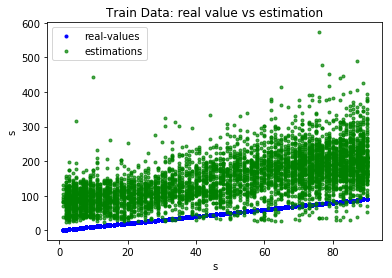

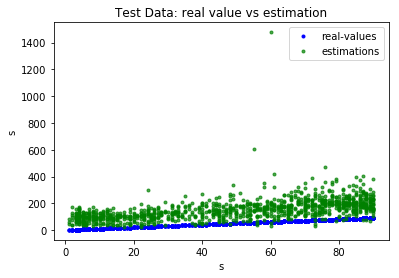

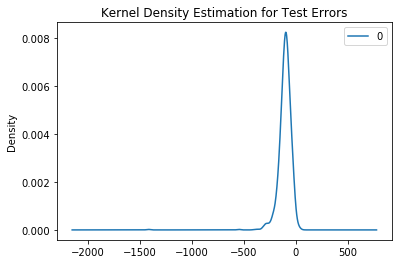

In [36]:
validation_rmsle["neural_nets"] = neural_nets_procedure(comp_data, params)

Model: random_forest
Train: 0.15689038972059227
Test: 0.4126068286083167


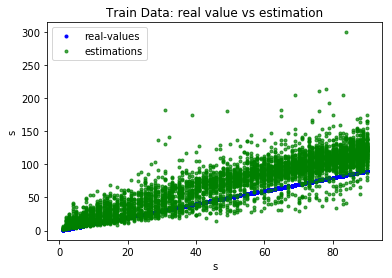

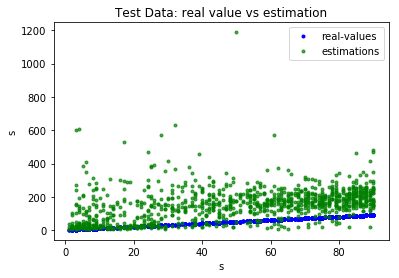

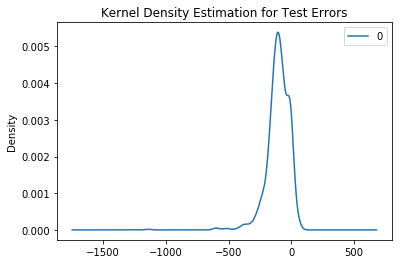

In [9]:
validation_rmsle["random_forest"] = random_forest_procedure(comp_data, params)

Model: boosted_trees
Train: 0.3472521983417782
Test: 0.4109641093584461


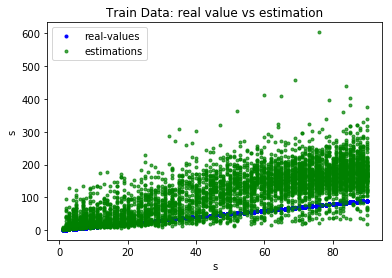

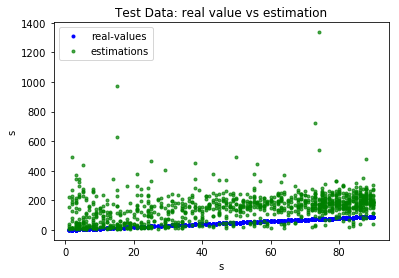

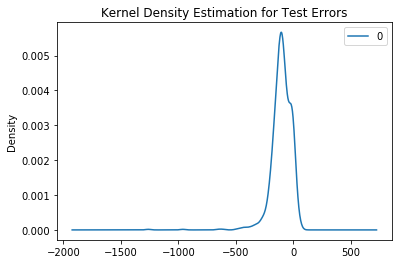

In [9]:
validation_rmsle["boosted_trees"] = boosted_trees_procedure(comp_data, params)

Model: svm
Train: 0.48644313686610147
Test: 0.4842099522053351


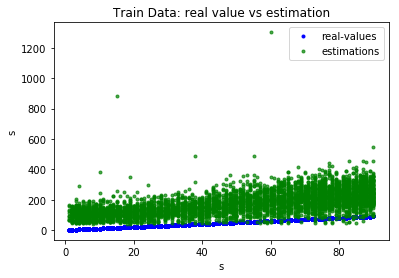

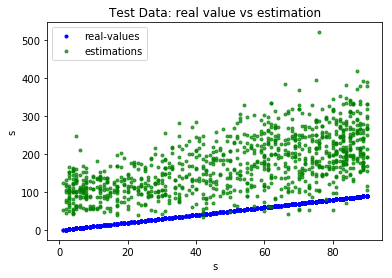

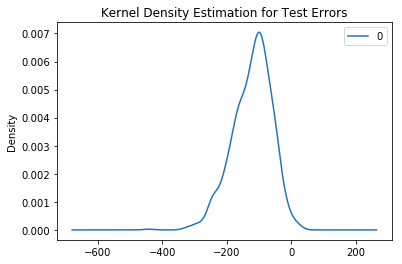

In [15]:
validation_rmsle["support_vector_machines"] = support_vector_machines_procedure(comp_data, params)

## Select model

Given the results in the prev. section, the selected model is: **random_forest**.

In [11]:
model = "boosted_trees"
final_score = "Validation score for {} model: {}".format(model, validation_rmsle[model])
print(final_score)

Validation score for boosted_trees model: 0.4156897294261908
